In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
from itertools import product

# feature analysis
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

# Processing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# SKLearn
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# SK-learn libraries for learning.

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

from sklearn import metrics


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


**Data Fields**

SOC, pH, Ca, P, Sand are the five target variables for predictions. The data have been monotonously transformed from the original measurements and thus include negative values.

- PIDN: unique soil sample identifier

- SOC: Soil organic carbon
- pH: pH values
- Ca: Mehlich-3 extractable Calcium
- P: Mehlich-3 extractable Phosphorus

- Sand: Sand content

- m7497.96 - m599.76: There are 3,578 mid-infrared absorbance measurements. For example, the "m7497.96" column is the absorbance at wavenumber 7497.96 cm-1. We suggest you to remove spectra CO2 bands which are in the region m2379.76 to m2352.76, but you do not have to.

- Depth: Depth of the soil sample (2 categories: "Topsoil", "Subsoil")

We have also included some potential spatial predictors from remote sensing data sources. Short variable descriptions are provided below and additional descriptions can be found at AfSIS data. The data have been mean centered and scaled.

- BSA: average long-term Black Sky Albedo measurements from MODIS satellite images (BSAN = near-infrared, BSAS = shortwave, BSAV = visible)
- CTI: compound topographic index calculated from Shuttle Radar Topography Mission elevation data
- ELEV: Shuttle Radar Topography Mission elevation data
- EVI: average long-term Enhanced Vegetation Index from MODIS satellite images.
- LST: average long-term Land Surface Temperatures from MODIS satellite images (LSTD = day time temperature, LSTN = night time temperature)
- Ref: average long-term Reflectance measurements from MODIS satellite images (Ref1 = blue, Ref2 = red, Ref3 = near-infrared, Ref7 = mid-infrared)
- Reli: topographic Relief calculated from Shuttle Radar Topography mission elevation data
- TMAP & TMFI: average long-term Tropical Rainfall Monitoring Mission data (TMAP = mean annual precipitation, TMFI = modified Fournier index)

In [114]:
# Load training data
X = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive

n = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  max_rows = 1,
                  names = True,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive
feature_names = np.asarray(n.dtype.names)

Depth = np.genfromtxt('training.csv',
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=3594) # Load Depth values

PIDN = np.genfromtxt('training.csv',
                    delimiter=',',
                    dtype=None,
                    skip_header = 1,
                    usecols=0) # Load the PIDN for reference

Ca = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3595) # Load Mehlich-3 extractable Calcium data

P = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3596) # Load Mehlich-3 extractable Phosphorus data

pH = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3597) # Load pH data

SOC = np.genfromtxt('training.csv', 
                    delimiter=',', 
                    dtype=None,
                    skip_header = 1,
                    usecols=3598) # Load Soil Organic Carbon data

Sand = np.genfromtxt('training.csv', 
                     delimiter=',', 
                     dtype=None,
                     skip_header = 1,
                     usecols=3599) # Load Sand Content data

# Outcome (or response) variable list
y_var_labels = ['Ca', 'P', 'pH', 'SOC', 'Sand']
y_vars = [Ca, P, pH, SOC, Sand]

# Color map for outcome variables
colors = ['orange', 'yellowgreen', 'powderblue', 'sienna', 'tan']


In [29]:
# Load test data
test_x = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=range(1, 3594)) # Load columns 0 to 3594 inclusive

test_ids = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=0) # Load columns 0 to 3594 inclusive


In [115]:
# Inspect the data shapes

print "Training data shape: ", X.shape
print "Feature name shape: ", feature_names.shape
print "PIDN data shape: ", PIDN.shape
print "Depth data shape: ", Depth.shape
print "Ca data shape: ", Ca.shape
print "P data shape: ", P.shape
print "pH data shape: ", pH.shape
print "SOC data shape: ", SOC.shape
print "Sand data shape: ", Sand.shape
print "Test data shape: ", test_x.shape
print "Test_ids shape: ", test_ids.shape

Training data shape:  (1157, 3593)
Feature name shape:  (3593,)
PIDN data shape:  (1157,)
Depth data shape:  (1157,)
Ca data shape:  (1157,)
P data shape:  (1157,)
pH data shape:  (1157,)
SOC data shape:  (1157,)
Sand data shape:  (1157,)
Test data shape:  (727, 3593)
Test_ids shape:  (727,)


Ca: total = 1157, max = 9.65, mean = 0.01, min = -0.54
P: total = 1157, max = 13.27, mean = -0.01, min = -0.42
pH: total = 1157, max = 3.42, mean = -0.03, min = -1.89
SOC: total = 1157, max = 7.62, mean = 0.08, min = -0.86
Sand: total = 1157, max = 2.25, mean = -0.01, min = -1.49


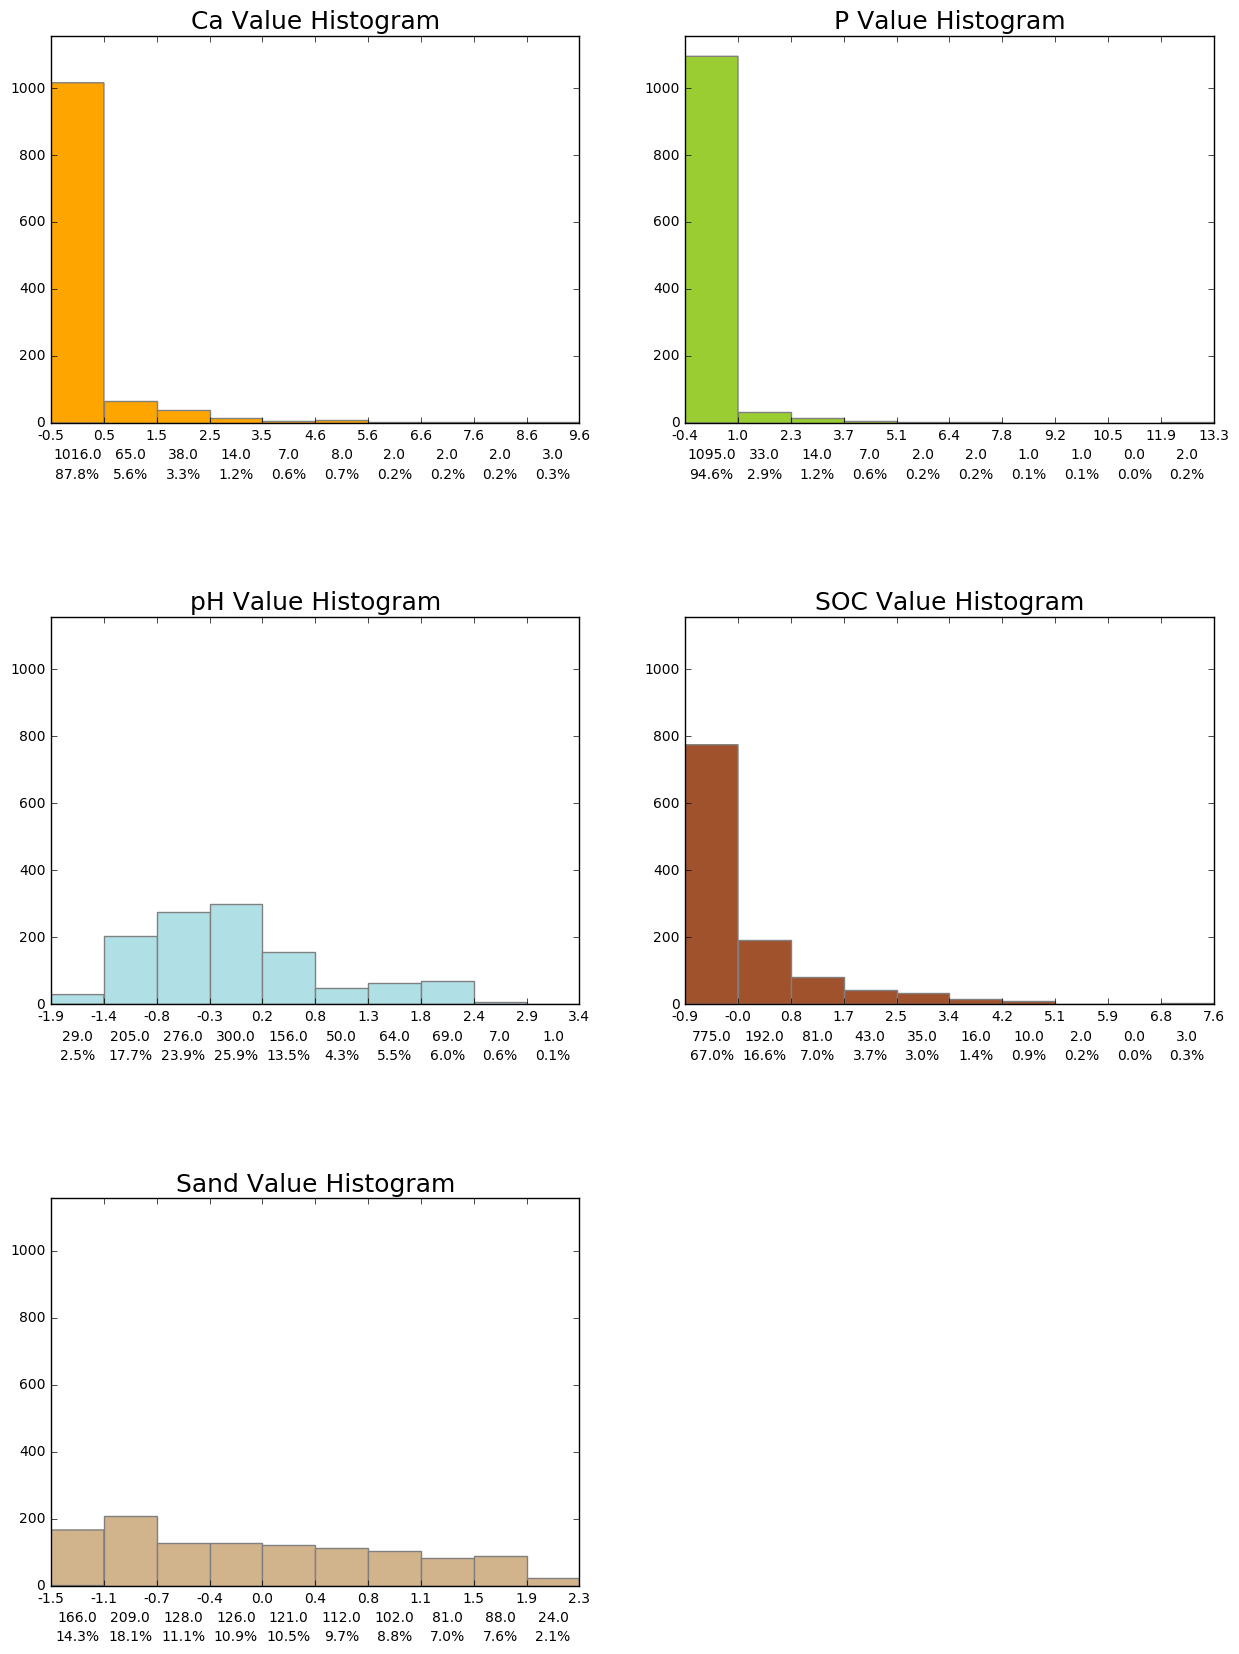

In [6]:
# Inspect the data in the five response variables

print "Ca: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Ca.shape[0], np.max(Ca), np.mean(Ca), np.min(Ca))
print "P: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (P.shape[0], np.max(P), np.mean(P), np.min(P))
print "pH: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (pH.shape[0], np.max(pH), np.mean(pH), np.min(pH))
print "SOC: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (SOC.shape[0], np.max(SOC), np.mean(SOC), np.min(SOC))
print "Sand: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Sand.shape[0], np.max(Sand), 
                                                                  np.mean(Sand), np.min(Sand))

def plot_hist(ind, data, max_y, title, color):

    counts, bins, patches = ax[ind].hist(data, facecolor=color, edgecolor='gray')
    # set the ticks to be at the edges of the bins.
    ax[ind].set_xticks(bins)
    # set the limits for x and y
    ax[ind].set_xlim([np.min(data),np.max(data)])
    ax[ind].set_ylim([0,max_y])
    # set the xaxis's tick labels to be formatted with 1 decimal place
    ax[ind].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax[ind].set_title(title, fontsize=18)
  
    # Label the raw counts and the percentages below the x-axis
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax[ind].annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.1f%%' % (100 * float(count) / counts.sum())
        ax[ind].annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


fig, ax = plt.subplots(3, 2, figsize=(15, 20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# Ca
plot_hist(0, Ca, Ca.shape[0], 'Ca Value Histogram', colors[0])
# P
plot_hist(1, P, P.shape[0], 'P Value Histogram', colors[1])
#pH
plot_hist(2, pH, pH.shape[0], 'pH Value Histogram', colors[2])
#SOC
plot_hist(3, SOC, SOC.shape[0], 'SOC Value Histogram', colors[3])
#Sand
plot_hist(4, Sand, Sand.shape[0], 'Sand Value Histogram', colors[4])
# delete the last subplot
fig.delaxes(ax[5])


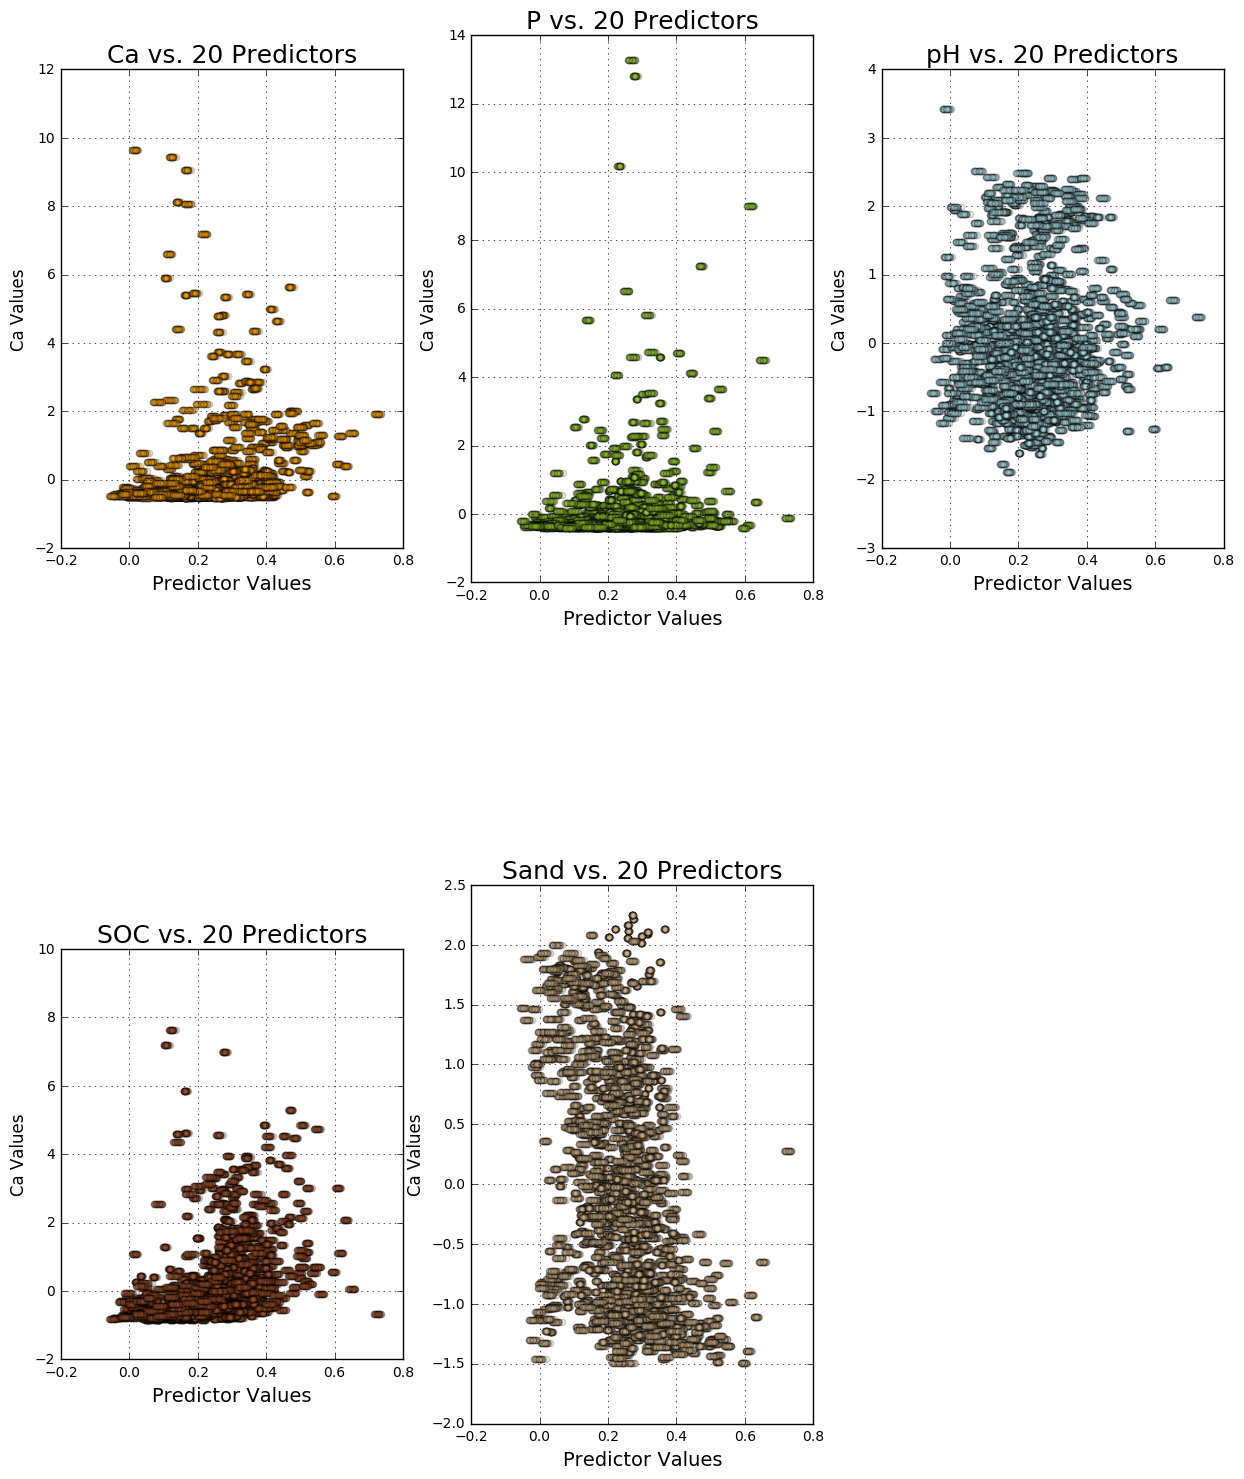

In [7]:
# Inspect the data in the predictor variables

def plot_data(ind, data_x, data_y, aspect, title, color):
    
    ax[ind].set_title(title, fontsize=18)
    ax[ind].set_xlabel('Predictor Values', fontsize=14)
    ax[ind].set_ylabel('Ca Values', fontsize=12)
    ax[ind].set_aspect(aspect = aspect, adjustable='box')
    ax[ind].grid(True)
    ax[ind].scatter(data_x, data_y, color = color, alpha = 0.2, marker = 'o', edgecolors = 'black')

# set up the grid plot
fig, ax = plt.subplots(2, 3, figsize=(15, 20))
#fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# select the predictor range (note this is influenced by the PCA below)
my_col = 20

X_sub = np.ravel(X[:,:my_col].reshape(-1,1))

# Ca 
plot_data(0, X_sub, np.repeat(Ca, my_col), 0.1, 'Ca vs. %d Predictors' % my_col, colors[0])
# P 
plot_data(1, X_sub, np.repeat(P, my_col), 0.1, 'P vs. %d Predictors' % my_col, colors[1])
#pH 
plot_data(2, X_sub, np.repeat(pH, my_col), 0.2, 'pH vs. %d Predictors' % my_col, colors[2])
#SOC 
plot_data(3, X_sub, np.repeat(SOC, my_col), 0.1, 'SOC vs. %d Predictors' % my_col, colors[3])
#Sand 
plot_data(4, X_sub, np.repeat(Sand, my_col), 0.35, 'Sand vs. %d Predictors' % my_col, colors[4])
# delete the last subplot
fig.delaxes(ax[5])



In [136]:
# Depth

vals, cnts = np.unique(Depth, return_counts = True)
print vals
print cnts

# CTI
print np.where(feature_names == 'CTI')[0]
vals, cnts = np.unique(X[:,3581], return_counts = True)
#print vals
#print cnts

# ELEV
print np.where(feature_names == 'ELEV')[0]
vals, cnts = np.unique(X[:,3582], return_counts = True)
#print vals
#print cnts

# m2379.76 to m2352.76 -> CO2 fields
print np.where(feature_names == 'm237976')[0]
vals, cnts = np.unique(X[:,3582], return_counts = True)
print cnts
print np.where(feature_names == 'm235276')[0]

['Subsoil' 'Topsoil']
[576 581]
[3581]
[3582]
[2654]
[ 2  4  2  2  2  2  2  2  2  4  4  6  2  1  2  8  6  2  4  4  4  2  6  4  8
  6  6  2  4  4  8  2  2  2 10  2  2  2  2  2  2  2  2  4  3  4  2  4  4  2
  4  2  2  6  2  2  2  2  4  2  2  2  4  4  4  4  6  2  8  4  4  6  4  2  2
  2  2  2  4  2  2  2  2  2  2  2  2  2  2  4  2  2  4  4  2  4  2  2  2  6
  6  2  2 10  2  4  2  2  6  4  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  6  1
  4  2  2  4  2  4  2  2  2  2  2  2  2  2  2  4  4  4  2  2  2  4  2  4  2
  6  6  6  8  6  2  2  2  2  2  4  2  2  2  2  4  2  2  2  2  2  2  2  2  2
  2  2  4  2  3  8  4  2  2  4  2  2  6  4  8  8  2  4  4  2  2  4  2  2  4
  2  4  4  2  2  2  2  2  2  2  2  2  2  2  2  6  2  6  2  4  3  4  2  2  2
  2  2  2  4  2  1  2  4  2  2  4  2  8  4  6  2  6  2  2  6  6  2  4  4  2
  2  2  2  2  2  2  2  2  2  2  4  2  1  2  4  1  4  2  4  2  2  4  2  6  2
  2  4  4  4  2  6  2  4  2  6  2  

**Which features have more impact?**

There are over three thousand features in this data, with few rows. Thus, we have a large k but small n data set to work with. Perhaps there are a subset of features to focus on.

Using PCA, we've identified that the first 73 features will explain 100% of the variance within the data. The first 20 features will cover 99.55% of the variance. Moving forward, we will focus on the first 20 features. 

Number of components: 
3593

-------------------------------------------
Fraction of the total variance in the training explained by first k components: 

1 	 70.54% 	 m749604
2 	 79.38% 	 m749411
3 	 85.54% 	 m749218
4 	 89.31% 	 m749025
5 	 91.69% 	 m748832
6 	 93.63% 	 m748639
7 	 95.14% 	 m748446
8 	 96.16% 	 m748254
9 	 96.75% 	 m748061
10 	 97.27% 	 m747868
11 	 97.74% 	 m747675
12 	 98.10% 	 m747482
13 	 98.42% 	 m747289
14 	 98.69% 	 m747097
15 	 98.90% 	 m746904
16 	 99.06% 	 m746711
17 	 99.20% 	 m746518
18 	 99.34% 	 m746325
19 	 99.44% 	 m746132
20 	 99.50% 	 m745939
21 	 99.56% 	 m745747
22 	 99.62% 	 m745554
23 	 99.67% 	 m745361
24 	 99.72% 	 m745168
25 	 99.75% 	 m744975
26 	 99.78% 	 m744782
27 	 99.81% 	 m744589
28 	 99.83% 	 m744397
29 	 99.85% 	 m744204
30 	 99.86% 	 m744011
31 	 99.88% 	 m743818
32 	 99.89% 	 m743625
33 	 99.90% 	 m743432
34 	 99.91% 	 m74324
35 	 99.92% 	 m743047
36 	 99.93% 	 m742854
37 	 99.93% 	 m742661
38 	 99.94% 	 m742468
39 	 99.94% 	 m7422

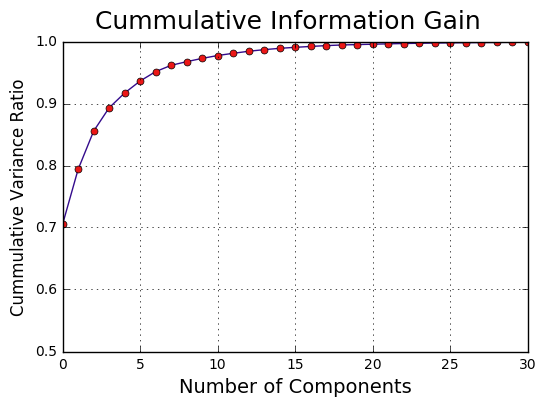

In [10]:
# Run PCA using all of the features
n_comp = feature_names.shape[0]
pca_all = PCA(n_components = n_comp)
pca_all.fit(X)

# Check outcome attributes
print 'Number of components: \n', pca_all.n_components_
#print 'Explained variance: \n', pca_all.explained_variance_
#print 'Explained variance ratio: \n', pca_all.explained_variance_ratio_ 
#print 'Cumulative explained variance: \n', np.cumsum(pca_all.explained_variance_ratio_)
#SANITY CHECK: print np.sum(pca_all.explained_variance_ratio_)
#print 'Mean: \n', pca_all.mean_
#print 'PCA components: \n', pca_all.components_ 

# Plot the Information Gain graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.cumsum(pca_all.explained_variance_ratio_), color = '#340B8C', marker = 'o', ms = 5, mfc = '#EB1717')
fig.suptitle('Cummulative Information Gain', fontsize=18)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cummulative Variance Ratio', fontsize=12)
plt.grid(True)
ax.set_xlim([0,30])
ax.set_ylim([0.5,1.0])
    
# Output variance fractions
print '\n-------------------------------------------'
print 'Fraction of the total variance in the training explained by first k components: \n'
for k in range(1,76):
    s = sum(pca_all.explained_variance_ratio_[0:k]) 
    #SANITY CHECK: print np.cumsum(pca_all.explained_variance_ratio_)[k-1]
    print("%d \t %s \t %s" % (k, '{0:.2f}%'.format(s * 100), feature_names[k]))


**IT IS AN ABSOLUTE MESS BELOW THIS POINT - ACTIVE WORKING AREA**

(867, 3593)
(290, 3593)
(867,)
(290,)
(290, 867)
(290,)


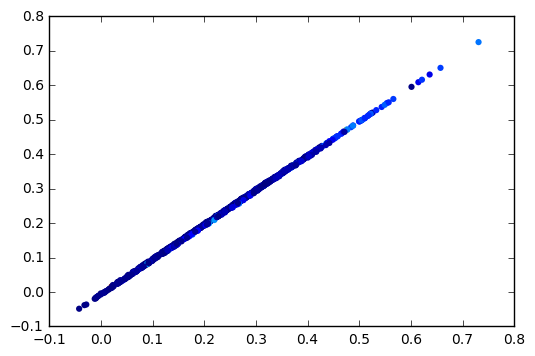

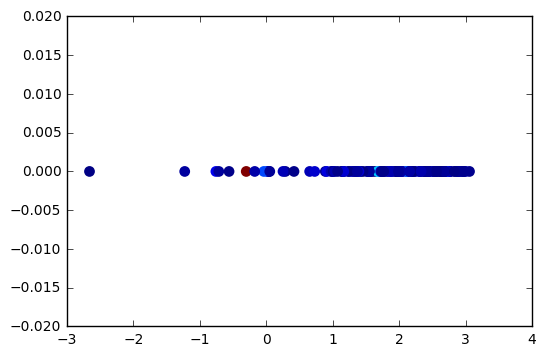

In [11]:
# Try a log transform on the PCA dataset

#transformer = FunctionTransformer(np.log1p)
#X = np.array([[0, 1], [2, 3]])
#transformer.transform(X)

# set up a pipeline of PCA(20), log transform, OLS Regression

pipeline = make_pipeline(
    PCA(), 
    FunctionTransformer(np.log1p),
    )

y = Ca
X_train, X_test, y_train, y_test = train_test_split(X, y)

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

pipeline.fit(X_train, y_train)
X_transformed, y_transformed = pipeline.transform(X_test), y_test

print X_transformed.shape
print y_transformed.shape

lw = 0
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, lw=lw)

plt.figure()
plt.scatter(
    X_transformed[:, 0],
    np.zeros(len(X_transformed)),
    c=y_transformed,
    lw=lw,
    s=60
)
plt.show()

(2, 1)
2
(2, 1)


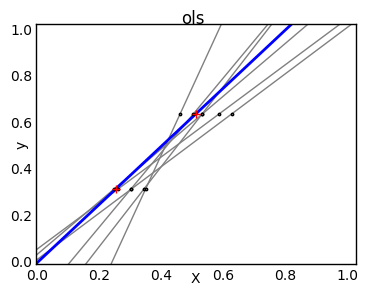

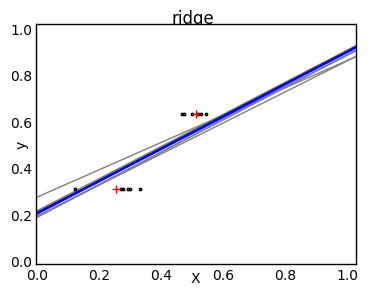

In [27]:
from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

print X_train.shape
print len(y_train)
print X_test.shape

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

fignum = 1
for name, clf in classifiers.items():
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.title(name)
    ax = plt.axes([.12, .12, .8, .8])

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='.5')
        ax.scatter(this_X, y_train, s=3, c='.5', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='r', marker='+', zorder=10)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_xlim(0, 2)
    fignum += 1

plt.show()

In [82]:
# Bunch of trialling

regr = LinearRegression()

pipeline = make_pipeline(
    PCA(), 
    FunctionTransformer(np.log1p),
    LinearRegression(),
    )

#######
y = Sand
X_train, X_test, y_train, y_test = train_test_split(X, y)

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

###### score for LinReg

regr.fit(X_train, y_train)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

# check shapes
print 'X_test shape: ', X_test.shape
print 'y_test shape: ', y_test.shape

# add pca for all then score

n_comp = 30 #feature_names.shape[0]
pca_all = PCA(n_components = n_comp)
X_pca = pca_all.fit(X_train).transform(X_train)

# transform the test_data using the PCA
Xt_pca = pca_all.transform(X_test)

# check shapes
print 'X_pca shape: ', X_pca.shape
print 'y_train shape: ', y_train.shape
print 'Xt_pca shape: ', Xt_pca.shape
print 'y_test shape: ', y_test.shape

regr.fit(X_pca, y_train)

# The coefficients
print '------------with PCA'
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(Xt_pca) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(Xt_pca, y_test))

# add transform to PCA then score

print X_pca
transformer = FunctionTransformer(np.log1p)
X_pcat = transformer.transform(X_pca)
print X_pcat

print 'X_pcat shape after transform: ', X_pcat.shape

imp = Imputer(missing_values='NaN', strategy='median')
X_pcat_imp = imp.fit(X_pcat).transform(X_pcat)
#imp.fit([[1, 2], [np.nan, 3], [7, 6]])
#X = [[np.nan, 2], [6, np.nan], [7, 6]]
#print(imp.transform(X)) 

print X_pcat_imp

regr.fit(X_pcat_imp, y_train)

# The coefficients
print '------------with PCA and Transform'
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(Xt_pca) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(Xt_pca, y_test))

#pipeline.fit(X_train, y_train)

#X_transformed, y_transformed = pipeline.transform(X_test), y_test

# OLS

#model_ols = OLS(y_train, X_pcat_imp, missing = 'drop')
#results = model_ols.fit()
#print(results.summary())

#model_ols = OLS(y_train, X_pcat, missing = 'drop')
#results = model_ols.fit()
#print(results.summary())

#X_plot = np.ravel(X_test[:,:].reshape(-1,1))
#print X_plot.shape
#y_plot = np.repeat(y_test, X_test.shape[1])
#print y_plot.shape

#plt.scatter(X_plot, y_plot,  color='black')
#plt.plot(X_plot, regr.predict(X_plot), color='blue',
#         linewidth=3)

#plt.xticks(())
#plt.yticks(())

#plt.show()

(867, 3593)
(290, 3593)
(867,)
(290,)
Mean squared error: 0.41
Variance score: 0.58
X_test shape:  (290, 3593)
y_test shape:  (290,)
X_pca shape:  (867, 30)
y_train shape:  (867,)
Xt_pca shape:  (290, 30)
y_test shape:  (290,)
------------with PCA
Mean squared error: 0.19
Variance score: 0.80
[[  1.61478176e+00  -2.91396680e+00  -2.15902805e+00 ...,   9.94257009e-03
    1.69556020e-01   2.07103731e-02]
 [  8.00598670e+00  -2.64767816e+00  -1.59845952e-01 ...,   1.53667215e-01
   -1.54342257e-02  -2.46437945e-02]
 [ -5.26268566e+00   2.55765967e+00  -3.46772618e+00 ...,  -3.21175925e-02
    2.20956110e-02   8.75328736e-03]
 ..., 
 [ -7.86728697e+00   1.79327804e+00  -2.73203948e+00 ...,  -1.38335812e-01
   -1.38539598e-01  -1.91701240e-01]
 [  1.26850643e+01  -1.92758042e+00  -9.78564737e-01 ...,   3.62034798e-02
   -8.17747937e-02  -8.21650306e-02]
 [ -1.19451416e+01  -1.49419804e+00   1.83784217e+00 ...,   1.76649690e-01
    2.31870457e-01  -5.08059027e-02]]
[[ 0.96118064         nan 

In [61]:
# Linear Regression with combination of PCA and Transformations (Log or StandardScaler?)

# set up options
pca_exec = [True, False]
pca_comp = list(range(20, 90, 10)) + ['all']
log_trans = [True, False]

# track output results
results = []

regr = LinearRegression()

# loop through the response variables to predict
for ind, y in enumerate(y_vars):
    
    # set up the train and test data
    print '\n----------', y_var_labels[ind]
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # check the data shapes
    #print 'X_train shape: ', X_train.shape
    #print 'y_train shape: ', y_train.shape
    #print 'X_test shape: ', X_test.shape
    #print 'y_test shape: ', y_test.shape
    
    # total tests per y
    num_tests = len(list(product(pca_exec, pca_comp, log_trans)))
    print 'num_test: ', num_tests
    
    # initial score
    # num_tests*len(y_vars)
    test_results = np.zeros(shape=(32, 6))
    print test_results.shape
    
    # header line
    print("index \t MSE \t Variance \t pca_exec \t pca_comp \t log_trans \t reg skip\n")
    
    # loop through the options    
    for i, p in enumerate(product(pca_exec, pca_comp, log_trans)):
        pe, pc, lt = p[0], p[1], p[2]
        
        # are we running PCA?
        if pe:
            n_comp = [pc, min(X_train.shape[0], X_train.shape[1])][pc == 'all']
            pca_model = PCA(n_components = n_comp)
            X_train2 = pca_model.fit(X_train).transform(X_train)
            # transform the X_test data using the PCA
            X_test2 = pca_model.transform(X_test)
        else:
            X_train2 = X_train
            X_test2 = X_test
        
        # check shapes
        #print 'X_train2 shape: ', X_train2.shape
        #print 'X_test2 shape: ', X_test2.shape
        
        # are we running log_trans?
        if lt:
            # create the log transformer
            logtrans = FunctionTransformer(np.log1p)
            X_trans = logtrans.transform(X_train2)
            # address the missing values from the transform
            imp = Imputer(missing_values='NaN', strategy='median')
            X_train3 = imp.fit(X_trans).transform(X_trans)
            # transform the X_test2 data? Do I apply the log transform to test as well?
            X_test3 = X_test2
        else:
            X_train3 = X_train2
            X_test3 = X_test2

        # check shapes
        #print 'X_train3 shape: ', X_train2.shape
        #print 'X_test3 shape: ', X_test2.shape
        
        # now run linear regresstion
        regr = LinearRegression()
        # check preprocessed data is adequate for linear regression
        #print pe, pc, lt
        nan_count, inf_count = np.count_nonzero(np.isnan(X_train3)), np.count_nonzero(np.isinf(X_train3))
        max_val, min_val = np.max(X_train3), np.min(X_train3)
        if (nan_count > 0 or inf_count > 0):
            mse = 0.0
            var = 0.0
            skip = 'Y'
        else:
            regr.fit(X_train3, y_train)
            # capture the mean square error and variance score
            mse = np.mean((regr.predict(X_test3) - y_test) ** 2)
            var = regr.score(X_test3, y_test)
            skip = 'N'
        
        n = [pc, min(X_train.shape[0], X_train.shape[1])][pc == 'all']
        if skip == 'N':
            test_results[i] = np.array([i, mse, var, pe, n, lt])
        print("%d \t %0.2f \t\t %0.2f \t\t %s \t\t %s \t\t %s \t\t %s" % (i, mse, var, pe, pc, lt, skip))
    
    results.append(test_results)
    


---------- Ca
num_test:  32
(32, 6)
index 	 MSE 	 Variance 	 pca_exec 	 pca_comp 	 log_trans 	 reg skip

0 	 0.52 		 0.59 		 True 		 20 		 True 		 N
1 	 0.22 		 0.83 		 True 		 20 		 False 		 N
2 	 0.41 		 0.67 		 True 		 30 		 True 		 N
3 	 0.15 		 0.88 		 True 		 30 		 False 		 N
4 	 0.40 		 0.68 		 True 		 40 		 True 		 N
5 	 0.12 		 0.91 		 True 		 40 		 False 		 N
6 	 0.47 		 0.63 		 True 		 50 		 True 		 N
7 	 0.11 		 0.91 		 True 		 50 		 False 		 N
8 	 0.46 		 0.63 		 True 		 60 		 True 		 N
9 	 0.12 		 0.91 		 True 		 60 		 False 		 N
10 	 0.48 		 0.62 		 True 		 70 		 True 		 N
11 	 0.11 		 0.92 		 True 		 70 		 False 		 N
12 	 0.49 		 0.61 		 True 		 80 		 True 		 N
13 	 0.10 		 0.92 		 True 		 80 		 False 		 N
14 	 26.40 		 -20.01 		 True 		 all 		 True 		 N
15 	 0.17 		 0.86 		 True 		 all 		 False 		 N
16 	 0.00 		 0.00 		 False 		 20 		 True 		 Y
17 	 0.17 		 0.86 		 False 		 20 		 False 		 N
18 	 0.00 		 0.00 		 False 		 30 		 True 		 Y
19 	 0.17 		 0.86 		 False 		 30

In [62]:
# Ca 0.10 True, 80 False
# P 0.52 True 20 False
# pH 0.14 True 70 False
# SOC 0.15 True 80 False
# Sand 0.14 True 80 False

n_comps = [80, 20, 70, 80, 80]

print test_x.shape
print test_ids.shape
print len(test_x)

# build the pieces
pca_models = []
regr_models = []

start = time()
for ind in range(0, 5):
    regr = LinearRegression()
    pca_models.append(PCA(n_components = n_comps[ind]))
    X_pca = pca_model.fit(X).transform(X)   
    regr_models.append(regr.fit(X_pca, y_vars[ind]))
print 'Completed: '


(727, 3593)
(727,)
727
[-0.48527017]
[ 0.19997887]
[-1.23937003]
[-0.50164431]
[ 1.59440139]
1
[[array([-0.48527017]), array([ 0.19997887]), array([-1.23937003]), array([-0.50164431]), array([ 1.59440139])]]


In [67]:
# Iterate through test samples

allPredictions = []

for s_ind in range(len(test_x)):
    
    sampleId = test_ids[s_ind]
    sample = test_x[s_ind]
    #print sampleId
    #print sample.shape
    
    currentSamplePredictions = []
    
    # Use the appropriate model to estimate the 5 outcome variables
    for ind in range(0, 5):
        # Grab selector and classifier
        #selector = models[ind][3]
        #classifier = models[ind][4]
        
        # Transform the input variables
        #selectedSample = selector.transform(sample.reshape(1, -1))
        
        # Predict
        #predicted = classifier.predict(selectedSample.reshape(1, -1))
        
        # Store
        #currentSamplePredictions.append(predicted[0])
        

        samp_data = pca_model.transform(sample.reshape(1, -1))
        
        pred = regr_models[ind].predict(samp_data.reshape(1, -1))[0]
        #print pred
        
        currentSamplePredictions.append(pred)
        
    
    allPredictions.append(currentSamplePredictions)
    
    #print len(allPredictions)
    #break
    
print allPredictions

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [68]:
print len(allPredictions)

727


In [70]:
# Generate csv for Kaggle

# Print header
header = 'PIDN,Ca,P,pH,SOC,Sand'
#np.savetxt('test.out', header, delimiter=',')  

filename = 'jc_linreg.csv'
# Clean file
open(filename, 'w').close()
with open(filename, 'w') as f:
    f.write('PIDN,Ca,P,pH,SOC,Sand\n')  # python will convert \n to os.linesep

    # Iterate through test samples
    for i in range(len(allPredictions)):

        pred = allPredictions[i]
        testId = test_ids[i]
        text = testId + ',' + str(pred[0]) + ',' + str(pred[1]) + ',' + str(pred[2]) + ',' + str(pred[3]) + ',' + str(pred[4]) + '\n'
        f.write(text) 
    
f.close()

In [ ]:
# Ridge Regression with combination of PCA and Transformations

In [ ]:
# SVR with conbimation of PCA and Transformations

**NOTES**

Options for high dimensional data where large number of features and fewer number of observations: can choose random sets of variables and asses their importance using cross-validation; ridge regression, the lasso or elastic net for regularization (process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting); choose a technique, such as a support vector machine or random forest that deals well with a large number of predictors.

LASSO (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

When considering ML methods, consider:
- the size of the training data
- the number of features
- the quality of features
- the number of unique class labels
- linear vs. non-linear problems

Always start simple: first algorithm to try would be naive Bayes, logistic regression, k-nearest neighbour (First start with one neighbour) and Fisher's linear discriminant before anything else. For advanced machine learning, ensemble methods are the ones that produces the best results as is shown by winners in kaggale competition and XGBOOST has been very popular among the kaggale winners. Neural Networks may be useful for predicting values but number of observations is low.

Subject: dirt quality for agriculture, Predictor variables: 3593 features (see feature_names), Response variables: 'Ca', 'P', 'pH', 'Soc', 'Sand

A continuous predictor variable is sometimes called a covariate and a categorical predictor variable is sometimes called a factor. In the cake experiment, a covariate could be various oven temperatures and a factor could be different ovens. Usually, you create a plot of predictor variables on the x-axis and response variables on the y-axis.

For continuous variables such as income, it is customary to do a log transformation to get it as close to a normal distribution as possible. You can then employ OLS and run some diagnostics to check your model fit. For other types of continuous variables, get a histogram and check the distribution. If it is somewhat normal, you can run an OLS and check the diagnostics and model fit.

References:

- https://stats.stackexchange.com/questions/253063/are-these-methods-suitable-for-predicting-a-numeric-value
- http://scikit-learn.org/stable/auto_examples/preprocessing/plot_function_transformer.html#sphx-glr-auto-examples-preprocessing-plot-function-transformer-py
